In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from sklearn.preprocessing import scale
from hmmlearn import hmm

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df = df.drop(['date_x','date_y','Date_x','Date_y'],axis=1)
X = df.values
print(X.shape)
date_range = pd.date_range(start='1/1/2000',end='1/26/2009')

(3314, 24)


In [4]:
dates = X[:,2]
prices = X[:,[5,6,7]]
print(dates.shape,prices.shape)
date_order = date_range.values
print(date_order.shape)

(3314,) (3314, 3)
(3314,)


In [7]:
df.head()


,Unnamed: 0,Price Hub,Trade Date,Delivery Start Date,Delivery End Date,High Price $/MWh,Low Price $/MWh,Wtd Avg Price $/MWh,Change,Daily Volume MWh,...,DHI,Pressure,Relative Humidity,Wind Speed,Open,High,Low,Close,Adj Close,Volume
0,0,PJM West,2001-01-02,2001-01-03,2001-01-03,65.5,64.5,65.00,NaN,1600,...,10899.537536,333825.486044,24807.885149,908.896006,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1.129400e+09
1,1,PJM West,2001-01-03,2001-01-04,2001-01-04,63.0,59.5,61.25,-3.75,3200,...,9436.261309,331530.197305,25660.590828,911.679211,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1.880700e+09
2,2,PJM West,2001-01-04,2001-01-05,2001-01-05,60.0,58.5,59.12,-2.13,4800,...,12108.243022,329297.608277,26548.007320,839.573580,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2.131000e+09
3,3,PJM West,2001-01-08,2001-01-09,2001-01-09,59.5,59.5,59.50,0.38,800,...,13144.172281,327948.291627,30604.138980,537.587199,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1.115500e+09
4,4,PJM West,2001-01-09,2001-01-10,2001-01-10,58.0,55.5,56.61,-2.89,5600,...,10884.741097,329242.584216,24703.976372,1128.615640,1295.859985,1311.719971,1295.140015,1300.800049,1300.800049,1.191300e+09


In [9]:
param = X[:,[18,19,20,21]]

In [30]:
df_mark = pd.DataFrame()
# df_mark['Close'] = X[:,21]
# df_mark['Open'] = X[:,18]
df_mark['High'] = X[:,5]
df_mark['Low'] = X[:,6]
df_mark['Avg'] = X[:,7]
df_mark.head()

,High,Low,Avg
0,65.5,64.5,65
1,63,59.5,61.25
2,60,58.5,59.12
3,59.5,59.5,59.5
4,58,55.5,56.61


In [18]:
df_mark = df_mark.dropna(how='any')

In [19]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

warnings.filterwarnings("ignore", category=DeprecationWarning)

PLOT_SHOW=True
PLOT_TYPE = False

NUM_TEST = 100
K = 50
NUM_ITERS=10000

In [31]:
labels = ['High','Low','Avg']
likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])

# Possible number of states in Markov Model
STATE_SPACE = range(2,15)


In [36]:
from sklearn.metrics import mean_squared_error

In [41]:
def calc_mape(predicted_data, true_data):
    return (np.divide(np.sum(np.power(np.absolute(predicted_data - true_data),2), 0), true_data.shape[0]))


In [33]:
STOCKS = ['data.csv']

In [34]:
for stock in STOCKS:
    dataset = df_mark.values
    predicted_stock_data = np.empty([0,dataset.shape[1]])
    likelihood_vect = np.empty([0,1])
    aic_vect = np.empty([0,1])
    bic_vect = np.empty([0,1])
    for states in STATE_SPACE:
        num_params = states**2 + states
        dirichlet_params_states = np.random.randint(1,50,states)
        #model = hmm.GaussianHMM(n_components=states, covariance_type='full', startprob_prior=dirichlet_params_states, transmat_prior=dirichlet_params_states, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
        model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
        model.fit(dataset[NUM_TEST:,:])
        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
        aic_vect = np.vstack((aic_vect, -2 * model.score(dataset) + 2 * num_params))
        bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))
    
    opt_states = np.argmin(bic_vect) + 2
    print('Optimum number of states are {}'.format(opt_states))

    for idx in reversed(range(NUM_TEST)):
        train_dataset = dataset[idx + 1:,:]
        test_data = dataset[idx,:]; 
        num_examples = train_dataset.shape[0]
        #model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', startprob_prior=dirichlet_params, transmat_prior=dirichlet_params, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
        if idx == NUM_TEST - 1:
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
        else:
            # Retune the model by using the HMM paramters from the previous iterations as the prior
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
            model.transmat_ = transmat_retune_prior 
            model.startprob_ = startprob_retune_prior
            model.means_ = means_retune_prior
            model.covars_ = covars_retune_prior

        model.fit(np.flipud(train_dataset))

        transmat_retune_prior = model.transmat_
        startprob_retune_prior = model.startprob_
        means_retune_prior = model.means_
        covars_retune_prior = model.covars_

        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        #print('Model score : ', model.score(dataset))
        #print('Dirichlet parameters : ',dirichlet_params)

        iters = 1;
        past_likelihood = []
        curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
        while iters < num_examples / K - 1:
            past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
            iters = iters + 1
        likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
        predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
        predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))
    np.savetxt('{}_forecast.csv'.format(stock),predicted_stock_data,delimiter=',',fmt='%.2f')


Optimum number of states are 13


In [42]:
 mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(100),:]))
print('MAPE for the stock {} is '.format('data.csv'),mape)


MAPE for the stock data.csv is  [86.001825 78.32740000000001 79.344102]


In [43]:
import math

In [45]:
print('root mean squared error on high prices',math.sqrt(mape[0]))
print('root mean squared error on low prices ',math.sqrt(mape[1]))
print('root mean squared error on avg prices',math.sqrt(mape[2]))

root mean squared error on high prices 9.273716892379236
root mean squared error on low prices  8.850276831828483
root mean squared error on avg prices 8.907530634244264


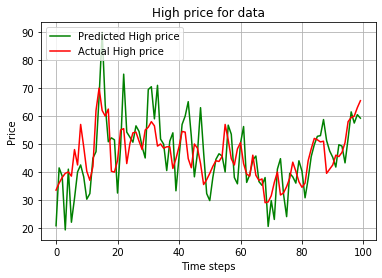

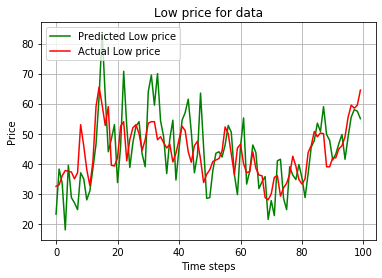

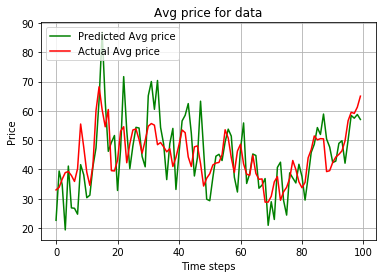

In [47]:
if PLOT_TYPE:
    hdl_p = plt.plot(range(100), predicted_stock_data);
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('High','Low','Avg'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(100),np.flipud(dataset[range(100),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('High','Low','Avg'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(3):
        plt.figure()
        plt.plot(range(100), predicted_stock_data[:,i],'g-', label = 'Predicted '+labels[i]+' price');
        plt.plot(range(100),np.flipud(dataset[range(100),i]),'r-', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')


if PLOT_SHOW:
    plt.show(block=False)